In [4]:
# import modules to handle files
import os
import glob
import shutil
from PIL import Image

# import modules to train models
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [5]:
def process_image(image_path):
  """
  Function to process image into the input format required
  for model
  """
  
  # read image
  im = Image.open(image_path)


  # define image to tensor transform
  im_transform = transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

  # unify image channels to 3
  im = np.asarray(im)
  if len(im.shape) == 2:
      im = im[:, :, None]
  if im.shape[2] == 1:
      im = np.repeat(im, 3, axis=2)
  elif im.shape[2] == 4:
      im = im[:, :, 0:3]

  # convert image to PyTorch tensor
  im = Image.fromarray(im)
  im = im_transform(im)#.cuda()

  # add mini-batch dim
  im = im[None, :, :, :]

  # resize image for input
  im_b, im_c, im_h, im_w = im.shape
  ref_size = 512
  if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
      if im_w >= im_h:
          im_rh = ref_size
          im_rw = int(im_w / im_h * ref_size)
      elif im_w < im_h:
          im_rw = ref_size
          im_rh = int(im_h / im_w * ref_size)
  else:
      im_rh = im_h
      im_rw = im_w

  im_rw = im_rw - im_rw % 32
  im_rh = im_rh - im_rh % 32
  im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

  return im

In [6]:
main_path = sys.path[0]
scnd_path = sys.path[0]+"\\MODNet"

os.chdir(scnd_path)
# import local modules
from src.models.modnet import MODNet

# define device
device = "cuda" if torch.cuda.is_available() else "cpu"

# rebuild model with same architecture as in training
modnet = torch.nn.DataParallel(MODNet()).to(device)

os.chdir(main_path)
# load model's state_dict
state_dict = torch.load(
    './model_checkpoint/model_checkpoint.pth',
    map_location=torch.device(device) # map to device
    )

# load state_dict into the network (works only if model architecture is the same as checkpoint architecture)
modnet.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:

# path to image
image_path = "./static/upload/0002-01.jpeg"

# process image into correct input format for model
im = process_image(image_path)

# predict alpha matte
_, _, matte = modnet(im, True)

# load image to get the original shape
image = np.asarray(Image.open(image_path))
print(image.shape)

# resize alpha matte to the original shape
im_h = image.shape[0]
im_w = image.shape[1]
matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
matte = matte[0][0].data.cpu().numpy()
print(matte.shape)

# save matte

Image.fromarray(((matte * 255).astype('uint8')), mode='L').save(os.path.join("./static/bgrm_result", "matte.png"))

C:\Users\sijal\anaconda3\envs\vision\lib\site-packages\torch\nn\functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
(657, 800, 3)
(657, 800)


In [6]:
def cut_out(image, matte) -> tuple:
  """
  Function to visualize results
  
  returns: tuple of images:
  * image cutout
  * image combining original image, image cutout, predicted alpha matte
  """
  # calculate display resolution
  print(image.shape)
  h, w = image.shape[0], image.shape[1]
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  Image.fromarray(((foreground).astype('uint8'))).save(os.path.join("./static/bgrm_result", "result.png"))
  foreground = Image.fromarray(np.uint8(foreground))
  
  return  foreground

(657, 800, 3)


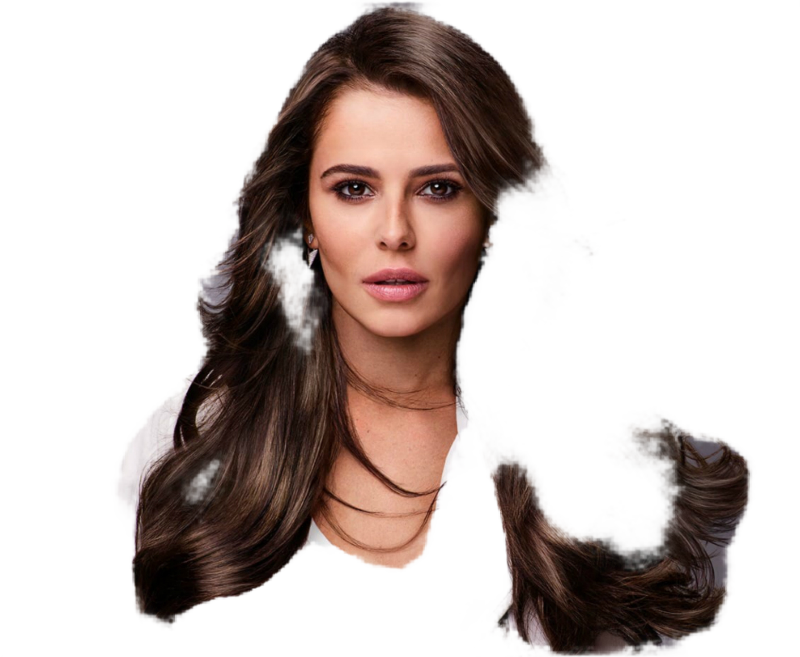

In [7]:
# visualize image cutout
matte = np.asarray(Image.open("./static/bgrm_result/matte.png"))
display(cut_out(image, matte))

In [ ]:
os.chdir(sys.path[0])


In [12]:
main_path

'c:\\01 D\\ML project\\Remove_Image_Background'

In [13]:
scnd_path

'c:\\01 D\\ML project\\Remove_Image_Background\\MODNet'